<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/main/(Custom_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!rm -rf /content/data_26
!cp -r /content/drive/MyDrive/Objectdetection/data_26 /content

In [13]:
!rm -rf /content/data_26/.ipynb_checkpoints
!rm -rf /content/data_26/test/.ipynb_checkpoints
!rm -rf /content/data_26/train/.ipynb_checkpoints

In [14]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [15]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        except:
            print("labels :")
            print(labels)
            print("boxes :")
            print(boxes)
            print(idx)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [17]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [32]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
num_classes=5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

In [33]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = CityDataset('/content/data_26/train', get_transform(train=True))
dataset_test = CityDataset('/content/data_26/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params = [param for param in model.parameters() if param.requires_grad]

optimizer = torch.optim.SGD(params, lr=1e-1, momentum=0.09,weight_decay=0.000005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/25]  eta: 0:00:25  lr: 0.004262  loss: 2.6114 (2.6114)  loss_classifier: 1.4752 (1.4752)  loss_box_reg: 0.4133 (0.4133)  loss_objectness: 0.6063 (0.6063)  loss_rpn_box_reg: 0.1167 (0.1167)  time: 1.0248  data: 0.6056  max mem: 2118
Epoch: [0]  [10/25]  eta: 0:00:06  lr: 0.045887  loss: 1.7813 (1.8443)  loss_classifier: 0.6912 (0.8715)  loss_box_reg: 0.6841 (0.6429)  loss_objectness: 0.1775 (0.2486)  loss_rpn_box_reg: 0.0792 (0.0814)  time: 0.4589  data: 0.0798  max mem: 2118
Epoch: [0]  [20/25]  eta: 0:00:02  lr: 0.087513  loss: 1.4484 (1.5664)  loss_classifier: 0.5922 (0.6837)  loss_box_reg: 0.6095 (0.6173)  loss_objectness: 0.1390 (0.1958)  loss_rpn_box_reg: 0.0624 (0.0696)  time: 0.3833  data: 0.0269  max mem: 2118
Epoch: [0]  [24/25]  eta: 0:00:00  lr: 0.100000  loss: 1.2517 (1.5053)  loss_classifier: 0.4349 (0.6355)  loss_box_reg: 0.6095 (0.6209)  loss_objectness: 0.1115 (0.1801)  loss_rpn_box_reg: 0.0614 (0.0689)  time: 0.3675  data: 0.0239  max mem: 2118
Epoch: [

In [34]:
total_params = sum(
	param.numel() for param in model.parameters()
)

In [35]:
total_params

18945604

In [20]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    print(scores)
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 701, 1054])
[0.9978564381599426, 0.9833959937095642, 0.9775160551071167, 0.9663448929786682, 0.9633824229240417, 0.9535512924194336, 0.9392324090003967, 0.9373047947883606, 0.9259219765663147, 0.9225990176200867, 0.919217586517334, 0.9149833917617798, 0.9128076434135437, 0.907873809337616, 0.8967365622520447, 0.8941375613212585, 0.889689028263092, 0.8894117474555969, 0.8678219318389893, 0.8605330586433411, 0.8303120136260986, 0.8251789808273315, 0.7888364791870117, 0.783779501914978, 0.7701094150543213, 0.7664046883583069, 0.757108211517334, 0.7427340745925903, 0.7374311089515686, 0.7349902987480164, 0.7189002633094788, 0.7116382718086243, 0.7038378119468689, 0.6876318454742432, 0.6493884921073914, 0.6484397649765015, 0.639258086681366, 0.6361953020095825, 0.6360070109367371, 0.6334039568901062, 0.6181334853172302, 0.6100459694862366, 0.6014746427536011, 0.5992887616157532, 0.572129487991333, 0.5692679286003113, 0.5385686755180359, 0.5214765667915344, 0.5094842314720154,

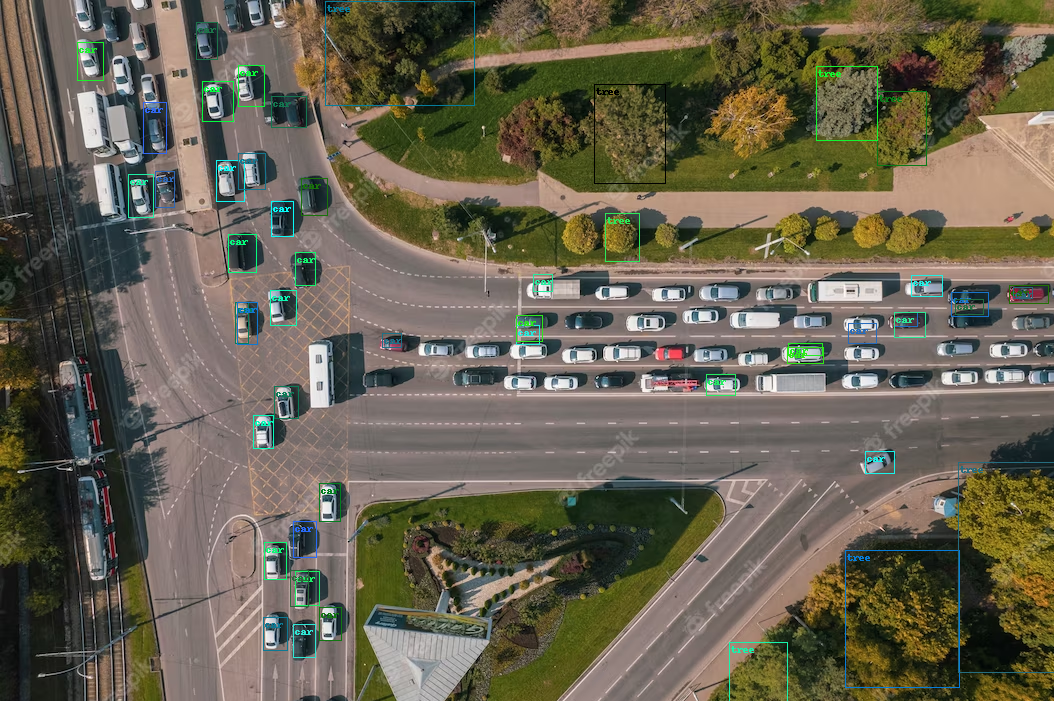

In [29]:

img, time_taken = get_inference('/content/test3.png', 0.5, model)
print(time_taken)
img.show()

In [25]:
torch.save(model.state_dict(), '/content/model_best_current.pt')
!cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model_best_current.pt'))
model1.to(device)
model1.eval()